# TRANSFORM
# Cleaning raw data from Women t-shirts from Amazon.es

Data was scraped on 2023-10-04 using `selenium` module and <br/>
stored as a pickle file in `../../data/raw/amz1_womentshirt_data.pk`

The raw `amz1_womentshirt_data` dataset has the following **structure**: <br/>
* Dictionary of lists - Each key divides the clothes by colors <br/>
* Color list of lists - Each list divides the clothes by amazon search page <br/>
* Each element of the list collects the data relative to one product <br/>

Now the data must be cleaned and transform to comply with the DDBB standards.

--------

Raw `amz1_womentshirt_data` dataset has the following issues:

* 1. Normalize the key names (colors) using `mlg.namvector_clean` function

* 2. Filter out irrelevant data. <br/> 
        * The ultimate goal is, for each element, to keep only the brand, product description and price €  
        * I made 3 functions to run along the pages `prod_clean_amz1`, `complete_price_amz1` and `relev_inf_amz1`
        * I will keep only the product containing 4 values **(brand, description, price, colour)**

* 3. Clean `price` column

* 4. Drop 21 rows with wrong `price/description`

* 5. Drop 24 rows with wrong `brand/description `

--------

Save cleaned data in `../../data/clean/amz1_womentshirt_data.pk`

### 0. Import modules

Import my module

In [559]:
import pickle
import pandas as pd
import warnings

#import pylab as plt   # import matplotlib.pyplot as plt#
import matplotlib.pyplot as plt

# print the plot in the jupyter output
%matplotlib inline 

from src import dataanalysis_fun1 as mlg 

Reload my module if neccessary

In [413]:
import importlib
from src import dataanalysis_fun1 as mlg # Import the module
#importlib.reload(mlg)  # Reload the module

# Suppress warning when reloading the module
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    importlib.reload(mlg)  # Reload the module

## 1. Load the data using pickle

In [416]:
with open('../../data/raw/amz1_womentshirt_data.pkl', 'rb') as file:
    amz1_womentshirt_data = pickle.load(file)

In [417]:
amz1_raw=amz1_womentshirt_data

## 2. Transform (clean the data)

### 2.1 Normalize the key names (colors)

In [418]:
keys_list=amz1_raw.keys()
keys_list2=mlg.namvector_clean(keys_list)

# Define the key changes
key_changes = dict(zip(keys_list, keys_list2))

# Create a new dictionary with the modified keys
amz1_raw2 = {key_changes.get(key, key): value for key, value in amz1_raw.items()}
amz1_raw2.keys()

dict_keys(['negro', 'gris', 'blanco', 'marron', 'beis', 'rojo', 'rosa', 'naranja', 'amarillo', 'marfil', 'verde', 'turquesa', 'azul', 'morado', 'dorado'])

### 2.2 Filter out irrelevant data

* The ultimate goal is, for each element, to keep only the brand, product description and price €  

* I made 3 functions to run along the pages `prod_clean_amz1`, `complete_price_amz1` and `relev_inf_amz1`

* I will keep only the product containing 4 values **(brand, description, price, colour)**

In [419]:

def prod_clean_amz1(prod_list, keys):    
    '''
    Keep elements that contain "€"" as it indicates they actually refer to a product
    Discard str lines including words (in ´keys_discard´) as it indicates they are irrelevant
    
    '''
    prod_list1=[]
    
    for theprod in prod_list:
        
        # if contains a price, it is a product, so continue!
        if "€" in "".join(theprod): 
            
            # eval if the str contains non-relevant info (keys_discard)    
            theprod1=[]
            for i in theprod:
                T=0
                # if the product element is to discard, > 0 
                T=sum((j in i) * 1 for j in keys) 
                
                # if the product element == 0 keep it for the moment
                if T == 0:
                    theprod1.append(i)
                else:
                    pass
                
            prod_list1.append(theprod1)
            
    return prod_list1



In [420]:

def complete_price_amz1(prod_list):
    '''
    sometimes the price get split by the comma.
    Eval if that is the case and correct it by joining the int value iof the index before
    
    '''
    prod_list1=[]
    for product in prod_list:
        
        # confirm the index of the price
        res=0
        for j in range(len(product)): 
            
            if ("Antes" in product[j]):
                product[j]=product[j].replace("€", "HAHAHA")
            
            
            
            if (("€" in product[j]) and ("Antes" in product[j])==False):
                res=j
                
        # if it includes € and , --> theprice is complete 
        if([("€" in t)*1 for t in product] == [("," in t)*1 for t in product]):
            #pass
            product[res]= product[res].replace(",", ".")
        
        # if it includes € but not , --> theprice is incomplete , paste the previous number
        else:
            ress= product[res-1] + "." + product[res]
            product[res]=ress
    
        prod_list1.append(product)
    
    
    return prod_list1



In [421]:
def relev_inf_amz1(product_list, color_val): # list with elements
    '''
    Take out float data referring to score rate and splited price
    Add a new column to register the color
    
    '''
    product_list1=[] # new list for containing cleaned elements
    for product in product_list:  # for each element containing values
        clean_prod=[] # new object for containing values of the cleaned element
        for prods in product: # for each value
            try:
                float(prods)
            except ValueError:
                if (prods != "Marca Amazon"):
                    clean_prod.append(prods) # if not floatable, keep it

        clean_prod = clean_prod + [color_val] #when the loop ends, add the color value
        
        product_list1.append(clean_prod) #add the cleaned elemnt to the list
    return product_list1

#### Run the cleaning functions -generated in previous cells- along pages and colors

In [424]:
color_list=list(amz1_raw2.keys())


keys_discard=["+", "Entrega", "Prime", "PVPR", "Patrocinado", "stock", "PROMO","Personalizarlo",
              "Oferta", "Ahorra", "Envío", "opción", "vendido", "Antes"]

color_df=pd.DataFrame(columns=["brand", "description", "price", "colour"])

for j in range(len(color_list)):
    test_color=amz1_raw2[color_list[j]]
    test_color1=[prod_clean_amz1(test,keys_discard) for test in test_color]
    test_color2=[complete_price_amz1(test) for test in test_color1]
    test_color3=[relev_inf_amz1(test, color_list[j]) for test in test_color2]

    for pag in range(len(test_negro3)): #by pages
        # print(color_list[j], "page:", pag)   
        
        # check the content of elements with size not equal 4
        ## [print((test)) for test in test_color3[pag] if len(test)!=4]

        test_color4=[test for test in test_color3[pag] if len(test)==4]

        for row in test_color4:
            row_df = pd.DataFrame([row], columns=color_df.columns)
            color_df = pd.concat([color_df, row_df], ignore_index=True)


In [432]:
color_df.loc[8557]

brand                                                 Street One
description    A318015 Camiseta de Hilo Flameado, Merry Yello...
price                                                  24.29,99€
colour                                                  amarillo
Name: 8557, dtype: object

###  There are some rows with super long  `brand/descriptions`!
I will correct this after cleaning `price`

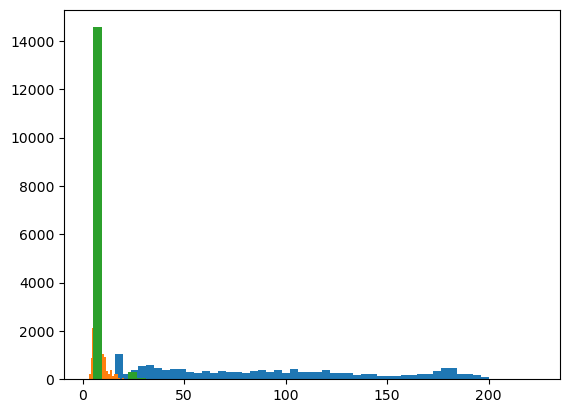

In [567]:
color_df1=color_df.copy()

character_counts = color_df1["description"].apply(len)
plt.hist(character_counts, bins=50);

character_counts = color_df1["brand"].apply(len)
plt.hist(character_counts, bins=50);

character_counts = color_df1["price"].apply(len)
plt.hist(character_counts, bins=50);

,brand,description,price,colour
69,Only,Onlonly S/S tee Jrs Noos-Camiseta de Manga Cor...,9.95 €(3 nuevas ofertas),negro
174,GRACE KARIN,Jersey Mujer Elegante Manga Larga Cuello Redon...,41.41 €(1 nueva oferta),negro
176,HERMKO,1560 Kit de 3 Camisetas de Tirantes 100% algod...,22.79 €(1 nueva oferta),negro
205,YSABEL MORA,Camiseta Manga Larga,19.95 €(1 nueva oferta),negro
219,RYTEJFES,"Jersey de Navidad para Mujer, algodón, Manga L...","4.15,82 €(1 nueva oferta)",negro
...,...,...,...,...
14144,ACVIP,Blusa china de manga corta con brocado Qipao p...,25.22 €(1 nueva oferta),dorado
14240,vepoty,Top Corto de Lentejuelas Brillantes para Mujer...,Top Corto de Lentejuelas Brillantes para Mujer...,dorado
14364,ZhuiKun,Camisetas Mujeres Lentejuela Embellecido Camis...,26.98 €(1 nueva oferta),dorado
14374,JUYLBLVE,Túnica Tops elegantes de manga larga para muje...,Túnica Tops elegantes de manga larga para muje...,dorado


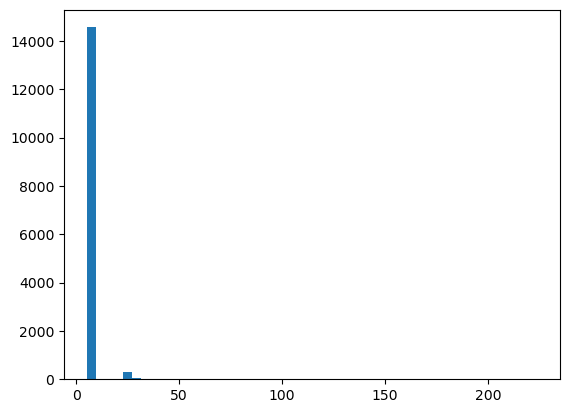

In [582]:
character_counts = color_df1["price"].apply(len)
plt.hist(character_counts, bins=50);
#plt.boxplot(character_counts);
color_df1[character_counts>20]

### 2.3 Clean `price` column

* Clean this kind of cells: 30.00 €(1 nueva oferta)
* Clean this kind of cells: 24.29,99€ --- > 29.99€
* Take out € sign and transform to float
* There is a huge number of wrong values in `price` column, for the moment, filter these out

In [669]:
color_df1=color_df.copy()
color_df1["price"]=[VAL.split("(")[0] for VAL in color_df1["price"]]
color_df1["price"]=[VAL.replace(" ", "") for VAL in color_df1["price"]]
color_df1["price"]=[VAL.replace("€", "") for VAL in color_df1["price"]]
color_df1.shape

(14940, 4)

In [670]:

for i in range(len(color_df1["price"])):
    if len(color_df1["price"][i].split(".")) > 3:
        #print(color_df1["price"][i].split("."))  # Drop rows with price > 3 elements
        color_df1['price'][i] = ""
    elif len(color_df1["price"][i].split(",")) == 2:
        try:
            #print(color_df1['price'][i].split(".")[-1])
            color_df1['price'][i] = color_df1['price'][i].split(".")[-1]
        except:
            row_todel+=i

color_df1 = color_df1[color_df1.price != ""]


### 2.4 Drop 21 rows with wrong `price/description`

In [671]:
display(len(color_df1[color_df1["price"].apply(len)>10]))

display(color_df1.shape)
color_df1=color_df1[color_df1["price"].apply(len)<10]
display(color_df1.shape)
color_df1 = color_df1[color_df1["price"] != ""]
display(color_df1.shape)

21

(14939, 4)

(14918, 4)

(14918, 4)

In [672]:
color_df1["price"]= color_df1['price'].str.replace(',', '.', regex=True)
color_df1['price'] = color_df1['price'].astype(float)
color_df1.shape

(14918, 4)

### 2.5 Drop 24 rows with wrong `brand/description `

In [673]:
display((color_df1[color_df1["brand"].apply(len)>30]))
display(color_df1.shape)
color_df1=color_df1[color_df1["brand"].apply(len)<30]
display(color_df1.shape)
color_df1

,brand,description,price,colour
35,Sugar Skull Shirt for Dia De Los Muertos Co.,Sugar Skull Shirt La Jefa Women The Boss Dia D...,16.99,negro
394,Los Eventos de la Tata. Detalles que enamoran,Camiseta de Mujer Moderna Princesas tatuadas,24.00,negro
637,Día de los Muertos La Catrina Day of the Dead ...,Día de los Muertos La Catrina Day of the Dead ...,17.89,negro
857,KOROSHI MANIAKS GRAPHIC DESIGN TM,Koroshi Camiseta de algodón de Manga Larga con...,39.99,negro
992,KOROSHI MANIAKS GRAPHIC DESIGN TM,Koroshi Camiseta de algodón de Manga Larga Cue...,35.99,negro
1046,Sugar Skull Shirt for Dia De Los Muertos Co.,Sugar Skull Shirt La Jefa Women The Boss Dia D...,16.99,gris
1648,KOROSHI MANIAKS GRAPHIC DESIGN TM,Koroshi Camiseta Blusa de Manga Larga con Esco...,29.99,gris
1690,SHOBDW Camisetas de manga larga,SHOBDW Liquidación Mujeres Sudadera Cuello Red...,7.99,gris
1873,SHOBDW Camisetas de manga larga,SHOBDW Moda para Mujer Casual Cuello con Solap...,6.99,gris
1949,Happiness & Silly Smiling Funny Premier Apparel,"Be, Happy Smile Funny Cute Happiness Kind Face...",14.99,gris


(14918, 4)

(14893, 4)

,brand,description,price,colour
0,Ranphee,Camisetas Túnica de Manga Larga para Mujer Blu...,25.99,negro
1,ANGGREK,Mujer Verano Tops Casual Encaje Cuello en V Ca...,31.19,negro
2,GRMLRPT,2023 Camiseta de Manga 3/4 Mujer Moda Cuello e...,25.99,negro
3,Urban Classics,Ladies Extended Shoulder tee Camiseta para Mujer,11.90,negro
4,Only,"Printed 3/4 Sleeved Top Suéter, Nero (Black/AO...",19.99,negro
...,...,...,...,...
14935,Generic,2024 Popular manga malla frío tops hombros sue...,6.98,dorado
14936,Generic,Blusa de Navidad 2024 de moda casual con lente...,10.32,dorado
14937,Generic,Blusa casual de manga suelta con lentejuelas p...,5.62,dorado
14938,Generic,Blusa de manga corta con cuello en V y lenteju...,17.19,dorado


In [678]:
display((color_df1[color_df1["brand"].apply(len)>20]))

,brand,description,price,colour
279,Tias Madrinas Comadres,Mujer Camisa Blusa para Tias y Tambien Madrina...,16.49,negro
476,United Colors of Benetton,Camiseta para Mujer,22.95,negro
583,Mirabella Health & Beauty,Casaca Chaqueta éstetica de Mujer Arete,35.29,negro
601,Regalos Cumpleaños Ellas,Mujer Me Ha Costado 50 Años Regalo 50 Cumpleañ...,19.99,negro
633,Mirabella Health & Beauty,Casaca Chaqueta éstetica de Mujer Freya,32.78,negro
...,...,...,...,...
13724,United Colors of Benetton,Camisa para Mujer,59.95,morado
13758,Boland BV Disco Party Shirt,35€-,25.62,morado
13825,United Colors of Benetton,Camiseta para Mujer,14.28,morado
13918,United Colors of Benetton,Blusa para Mujer,49.95,morado


In [687]:
color_df1["price"].mean()
display(color_df1.groupby('colour')['price'].mean())
display(color_df1.groupby('brand')['price'].mean())

colour
amarillo    22.471774
azul        25.479811
beis        22.501763
blanco      26.148116
dorado      16.980941
gris        22.344172
marfil      28.369498
marron      24.428018
morado      22.434886
naranja     23.624206
negro       24.443517
rojo        24.398558
rosa        24.777992
turquesa    21.249857
verde       24.637419
Name: price, dtype: float64

brand
13MW            34.9900
24 JOYAS        19.9500
365-Shopping    16.9900
3styler         20.0000
3stylershop     18.0000
                 ...   
wuchun          19.9900
xixirimido      26.5700
xrbanime        19.9900
yeyity          42.9900
yiouyisheng     13.9875
Name: price, Length: 1320, dtype: float64

## 3. Save cleaned data

In [688]:
amz1_womentshirt_clean=color_df1.copy()
#amz1_womentshirt_clean.to_csv('../../data/clean/amz1_womentshirt_clean.csv', index=False)